## 一、查看训练数据集

In [3]:
# 注册数据集
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from mpvit import add_mpvit_config  # register data here


# register_coco_instances("pest_train", {}, "datasets/coco/annotations/instances_train2017.json", "datasets/coco/train2017")
# register_coco_instances("pest_val", {}, "datasets/coco/annotations/instances_val2017.json", "datasets/coco/val2017")

# 获取数据集元数据
pest_metadata = MetadataCatalog.get('pest_train')
pest_train_dataset = DatasetCatalog.get('pest_train')  # list of dict


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [4]:
# 查看元数据内容
pest_train_dataset[0]

{'file_name': 'datasets/coco/train2017/00004.jpg',
 'height': 3648,
 'width': 5472,
 'image_id': 0,
 'annotations': []}

In [5]:
# 查看有标注的数据

idxs = []  # 所有有标注图片的index
for id, meta_ in enumerate(pest_train_dataset):
    if meta_['annotations']:
        print(meta_['file_name'])
        idxs.append(id)

datasets/coco/train2017/01090.jpg
datasets/coco/train2017/02363.jpg
datasets/coco/train2017/03565.jpg
datasets/coco/train2017/00197.jpg
datasets/coco/train2017/00571.jpg
datasets/coco/train2017/03496.jpg
datasets/coco/train2017/01791.jpg
datasets/coco/train2017/03144.jpg
datasets/coco/train2017/02103.jpg
datasets/coco/train2017/03753.jpg


In [11]:
# 可视化检查

from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt


row, col = 5, 2

plt.figure(figsize=(12, 20))

for i in range(row):
    for j in range(col):
        idx = i * col + j
        plt.subplot(row, col, idx + 1)
        plt.axis('off')

        meta_ = pest_train_dataset[idxs[idx]]
        img = plt.imread(meta_['file_name'])

        v = Visualizer(img, metadata=pest_metadata, scale=0.5)
        out = v.draw_dataset_dict(meta_)
        plt.imshow(out.get_image())

## 二、使用预训练模型预测图片

In [ ]:
import matplotlib.pyplot as plt


# img_path = 'datasets/raw_data/images/02363.jpg'
img_path = 'datasets/coco/train2017/03565.jpg'
img = plt.imread(img_path)
print(img.shape)
plt.imshow(img)

In [24]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from mpvit import add_mpvit_config


cfg = get_cfg()
# add_coat_config(cfg)
add_mpvit_config(cfg)
cfg.merge_from_file('configs/maskrcnn/mask_rcnn_mpvit_small_ms_3x.yaml')
cfg.MODEL.WEIGHTS = 'output/mask_rcnn_mpvit_small_ms_3x/model_final.pth'
cfg.freeze()
predictor = DefaultPredictor(cfg)
outputs = predictor(img)

In [25]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


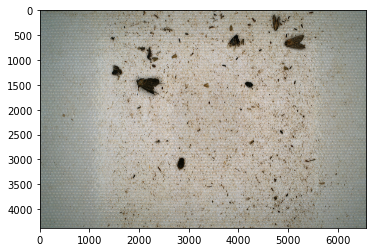

In [26]:
# We can use `Visualizer` to draw the predictions on the image.

from detectron2.utils.visualizer import Visualizer


v = Visualizer(img, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())